In [1]:
# import necessary libraries
import pandas as pd
import pandas as pd
import numpy as np
import ast
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# load the necessary files
filteredMatchDetails = pd.read_csv('../dataset/filteredMatchDetails.csv')
assistsMapDF = pd.read_csv('../dataset/assistsMap.csv', header=0)

In [3]:
filteredMatchDetails.columns

Index(['gameId', 'gameDuration', 'puuid', 'summonerId', 'teamId', 'win',
       'teamPosition', 'champExperience', 'kills', 'assists', 'turretKills',
       'epicMonsterKills', 'visionScore', 'visionWardsBoughtInGame',
       'magicDamageDealtToChampions', 'deaths', 'totalMinionsKilled',
       'timeCCingOthers', 'totalDamageTaken', 'totalHealsOnTeammates',
       'totalTimeSpentDead', 'goldEarned', 'objectivesStolen',
       'objectivesStolenAssists', 'participantId', 'participantsAssisted',
       'towerKillsAssisted', 'monsterKillsAssisted',
       'participantsAssistedWithPressure', 'queueType', 'tier', 'rank',
       'leaguePoints', 'matchPlayerCounts', 'summonerGamesPlayed', 'tierRank',
       'playerNumericalRank', 'matchAverageRank', 'teamAverageRank',
       'totalTeamGold', 'totalTeamGPM', 'totalTeamKills', 'totalTeamKPM',
       'totalTeamDeaths', 'totalTeamAssists', 'totalTeamAPM',
       'totalTeamEpicMonsterKills', 'totalTeamTurretKills',
       'totalTeamVisionScore', 't

In [4]:
assistsMapDF.columns

Index(['gameId', 'teamId', 'win', 'teamPosition', 'teamAverageRank',
       'matchAverageRank', 'participantId', 'kills', 'deaths', 'assists',
       'participantsAssisted', 'towerKillsAssisted', 'monsterKillsAssisted',
       'participantsAssistedWithPressure', 'totalAssisted', 'totalTeamKills',
       'totalTeamAssists', 'totalTeamTurretKills', 'totalTeamEpicMonsterKills',
       'totalTeamAllKills', 'totalTeamAllAssists', 'totalTeamGPM',
       'totalTeamKPM', 'totalTeamExpPerMin', 'totalTeamVPM', 'totalTeamAPM',
       'totalTeamMinionsPerMin', 'totalAssistsMap', 'playerTotalOutdegree',
       'playerTotalIndegree', 'teamMaxIndegree', 'teamTotalIndegree',
       'playerDiffMaxTeamIndegree', 'playerDiffMaxTeamIndegreeSum',
       'teamIndegreeCentrality', 'teamMaxOutdegree', 'teamTotalOutdegree',
       'playerDiffMaxTeamOutdegree', 'playerDiffMaxTeamOutdegreeSum',
       'teamOutdegreeCentrality', 'teamWeightCentralization', 'uniqueTeamId',
       'resistance'],
      dtype='object

In [5]:
## team average in-game performance metrics

filteredMatchDetails['uniqueTeamId'] = filteredMatchDetails['gameId'].astype(str) + '_' + filteredMatchDetails['teamId'].astype(str)
filteredMatchDetails['averageTeamKAPM'] = filteredMatchDetails['totalTeamAPM'] / 5 # average kill assists per minute
filteredMatchDetails['averageTeamAllAssistsPerMin'] = filteredMatchDetails['totalTeamAllAssists'] / (filteredMatchDetails['gameDuration'] * 5)
filteredMatchDetails['averageTeamExpPerMin'] = filteredMatchDetails['totalTeamExpPerMin'] / 5
filteredMatchDetails['averageTeamGoldPerMin'] = filteredMatchDetails['totalTeamGPM'] / 5
filteredMatchDetails['averageTeamMinionsPerMin'] = filteredMatchDetails['totalTeamMinionsPerMin'] / 5
filteredMatchDetails['averageTeamVPM'] = filteredMatchDetails['totalTeamVPM'] / 5
filteredMatchDetails['averageTeamGoldPerMin'] = filteredMatchDetails['totalTeamGPM'] / 5

print("Unique team IDs: ", filteredMatchDetails['uniqueTeamId'].nunique())

teamAveragePerformanceMetrics = filteredMatchDetails[['gameId', 'teamId', 'win', 'averageTeamKAPM', 'averageTeamAllAssistsPerMin', 'averageTeamExpPerMin', 'averageTeamGoldPerMin', 'averageTeamMinionsPerMin', 'averageTeamVPM']]
print(teamAveragePerformanceMetrics.shape)

# the above should contain duplicates because it was originally player level data which was averaged, so we drop duplicates
teamAveragePerformanceMetrics.drop_duplicates(inplace=True)
print(teamAveragePerformanceMetrics.shape)

## team graph metrics
teamGraphMetrics = assistsMapDF[['gameId', 'teamId', 'teamIndegreeCentrality', 'teamOutdegreeCentrality', 'resistance']]
print(teamGraphMetrics.shape)

teamGraphMetrics.drop_duplicates(inplace=True) # drop duplicates, because it also contains individual player level data
print(teamGraphMetrics.shape)

## merge the two dataframes
teamFeatures_df = pd.merge(teamAveragePerformanceMetrics, teamGraphMetrics, on=['gameId', 'teamId'], how='inner')
teamFeatures_df['teamIndegreeCentrality'] = teamFeatures_df['teamIndegreeCentrality'].fillna(0)
teamFeatures_df['teamOutdegreeCentrality'] = teamFeatures_df['teamOutdegreeCentrality'].fillna(0)
teamFeatures_df['resistance'] = teamFeatures_df['resistance'].fillna(0)

print(teamFeatures_df.shape)

Unique team IDs:  62110
(310550, 9)
(62110, 9)
(310550, 5)
(62110, 5)
(62110, 12)


/tmp/ipykernel_9701/656221265.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teamAveragePerformanceMetrics.drop_duplicates(inplace=True)
/tmp/ipykernel_9701/656221265.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teamGraphMetrics.drop_duplicates(inplace=True) # drop duplicates, because it also contains individual player level data


In [6]:
# perform correlation tests
from patsy import dmatrices
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# using original set of metrics before, we had share of the match
teamPerformance_features = teamFeatures_df[[   
    'averageTeamKAPM', 'averageTeamAllAssistsPerMin', 'averageTeamExpPerMin',
    'averageTeamGoldPerMin', 'averageTeamMinionsPerMin', 'averageTeamVPM',
    'teamIndegreeCentrality', 'teamOutdegreeCentrality', 'resistance'                   
]]

correlation_matrix = teamPerformance_features.corr()

# Function to calculate p-values
def correlation_test(x, y):
    return stats.pearsonr(x, y)

# Calculating p-values
p_values = pd.DataFrame(index=teamPerformance_features.columns, columns=teamPerformance_features.columns)

for col1 in teamPerformance_features.columns:
    for col2 in teamPerformance_features.columns:
        if col1 == col2:
            p_values[col1][col2] = np.nan  # NaN for the diagonal
        else:
            corr_test = correlation_test(teamPerformance_features[col1], teamPerformance_features[col2])
            p_values[col1][col2] = corr_test[1]  # Extract the p-value

# print(p_values)

print("Correlation Matrix:")

correlation_matrix

Correlation Matrix:


/tmp/ipykernel_9701/3221729789.py:25: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  p_values[col1][col2] = np.nan  # NaN for the diagonal
/tmp/ipykernel_9701/3221729789.py:28: FutureWarning: ChainedAssignmentError: behaviour will change in p

,averageTeamKAPM,averageTeamAllAssistsPerMin,averageTeamExpPerMin,averageTeamGoldPerMin,averageTeamMinionsPerMin,averageTeamVPM,teamIndegreeCentrality,teamOutdegreeCentrality,resistance
averageTeamKAPM,1.000000,0.935444,0.558568,0.721986,-0.049764,0.292771,-0.183778,-0.197935,-0.615455
averageTeamAllAssistsPerMin,0.935444,1.000000,0.658321,0.803360,-0.031586,0.304238,-0.200982,-0.227045,-0.650958
averageTeamExpPerMin,0.558568,0.658321,1.000000,0.835947,0.301103,0.261681,-0.170162,-0.136020,-0.524268
averageTeamGoldPerMin,0.721986,0.803360,0.835947,1.000000,0.290587,0.345610,-0.180872,-0.109565,-0.558254
averageTeamMinionsPerMin,-0.049764,-0.031586,0.301103,0.290587,1.000000,0.348216,0.052068,0.146122,0.068009
averageTeamVPM,0.292771,0.304238,0.261681,0.345610,0.348216,1.000000,-0.073530,-0.077193,-0.261587
teamIndegreeCentrality,-0.183778,-0.200982,-0.170162,-0.180872,0.052068,-0.073530,1.000000,0.271777,0.300168
teamOutdegreeCentrality,-0.197935,-0.227045,-0.136020,-0.109565,0.146122,-0.077193,0.271777,1.000000,0.334834
resistance,-0.615455,-0.650958,-0.524268,-0.558254,0.068009,-0.261587,0.300168,0.334834,1.000000


<span style="color: green;"> Above correlation analysis shows that kills assists is highly correlated with all assists for the team. So we remove that from our variable consideration </span>

In [7]:
teamPerformance_features.drop(['averageTeamKAPM', 'averageTeamAllAssistsPerMin', 'averageTeamMinionsPerMin'], axis=1, inplace=True)
print(teamPerformance_features.shape)

(62110, 6)


/tmp/ipykernel_9701/1062523468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teamPerformance_features.drop(['averageTeamKAPM', 'averageTeamAllAssistsPerMin', 'averageTeamMinionsPerMin'], axis=1, inplace=True)


### VIF on player performance features

In [8]:
# Perform VIF test on player performance features
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm 

# Add a constant for the intercept
X = sm.add_constant(teamPerformance_features)

# Compute VIF for each variable
vif_data = pd.DataFrame()
vif_data['features'] = teamPerformance_features.columns
vif_data['VIF'] = [ variance_inflation_factor(teamPerformance_features.values, i) for i in range(teamPerformance_features.shape[1]) ]

print(vif_data)

                  features         VIF
0     averageTeamExpPerMin  312.366835
1    averageTeamGoldPerMin  338.230975
2           averageTeamVPM   28.704464
3   teamIndegreeCentrality    6.279906
4  teamOutdegreeCentrality    6.806554
5               resistance    2.632753


<span style="color: green;">VIF test doesn't yield good results; all average metrics have VIF value > 5 when considering with 3 graph metrics + any other team average performance metrics

### Scree analysis to detect number of factors

In [9]:
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

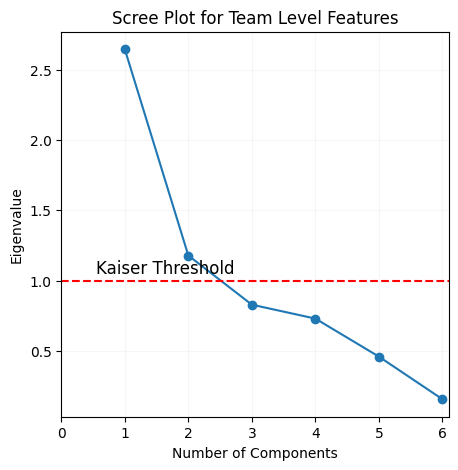

In [10]:
# scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(teamPerformance_features)

pca = PCA()
pca.fit(features_scaled)


# Plot the Scree Plot
plt.figure(figsize=(5,5))
plt.plot(np.arange(1, len(pca.explained_variance_)+1), pca.explained_variance_, marker='o')
plt.axhline(y=1, color='r', linestyle='--')
plt.text(0.55, 1.05, 'Kaiser Threshold', color='black', fontsize=12)
plt.title('Scree Plot for Team Level Features')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.grid(axis='both', alpha=0.1)
plt.xlim(0, 6.1)
plt.show()

<span style="color:green;"> Scree analysis suggests optimal number of latent factors to be 2</span>

### KMO test to check for suitability of Factor analysis

In [11]:
# performing KMO test on the dataset to see if dataframe is suitable for factor analysis
from factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(features_scaled)

# Print the results
print(f"KMO Overall: {kmo_model:.4f}")

# If you want to see individual KMO values for each variable:
print("Individual KMO values:\n", kmo_all)

KMO Overall: 0.6891
Individual KMO values:
 [0.64441694 0.62811565 0.82517065 0.77096904 0.63647265 0.82314779]


<span style="color:yellow;"> Overall KMO Value for team-level data is 0.69 which is considerably good for factor analysis</span>

In [12]:
# Perform Factor Analysis
fa = FactorAnalysis(n_components=2, rotation='varimax', max_iter=2000)  # Adjust n_components based on Scree Plot; making the number of components as 2, because we dont see a good distinction of features with 3 latent factors
fa.fit(features_scaled)
factor_loadings = fa.components_.T

# factor loadings for each feature column
loadings_df = pd.DataFrame(factor_loadings, index=teamPerformance_features.columns, columns=[f'Factor{i+1}' for i in range(factor_loadings.shape[1])])

# compute factor scores
factor_scores = fa.transform(features_scaled)
factor_scores_df = pd.DataFrame(factor_scores, columns=[f'Factor{i+1}' for i in range(factor_scores.shape[1])])

In [13]:
loadings_df

,Factor1,Factor2
averageTeamExpPerMin,-0.840376,-0.131060
averageTeamGoldPerMin,-0.983613,-0.069922
averageTeamVPM,-0.341423,-0.103194
teamIndegreeCentrality,0.151792,0.430343
teamOutdegreeCentrality,0.069633,0.585924
resistance,0.532036,0.515258


<span style="color:green;">The loading factors suggest that they can be separated as `cooperative` vs `non co-operative`. as in centralization and non-centralization of resources</span>

In [14]:
loadings_df.rename(columns={'Factor1': 'CooperativeFactor', 'Factor2': 'NonCooperativeFactor'}, inplace=True)
loadings_df

,CooperativeFactor,NonCooperativeFactor
averageTeamExpPerMin,-0.840376,-0.131060
averageTeamGoldPerMin,-0.983613,-0.069922
averageTeamVPM,-0.341423,-0.103194
teamIndegreeCentrality,0.151792,0.430343
teamOutdegreeCentrality,0.069633,0.585924
resistance,0.532036,0.515258


In [15]:
# rename columns for better understanding
factor_scores_df.rename(columns={'Factor1': 'CooperativeFactor', 'Factor2': 'NonCooperativeFactor'}, inplace=True)
print(factor_scores_df.shape)


(62110, 2)


In [16]:
## concatenate the factor scores df with the player performance features
win_info = teamFeatures_df[['gameId', 'teamId', 'win']]
factors_with_win_info = pd.concat([win_info, teamPerformance_features, factor_scores_df], axis=1)
print(factors_with_win_info.shape)
factors_with_win_info

(62110, 11)


,gameId,teamId,win,averageTeamExpPerMin,averageTeamGoldPerMin,averageTeamVPM,teamIndegreeCentrality,teamOutdegreeCentrality,resistance,CooperativeFactor,NonCooperativeFactor
0,EUW1_7139824479,100,0,439.862735,367.2,0.926542,0.227941,0.080882,0.6500,0.731456,-0.738828
1,EUW1_7139824479,200,1,451.058445,387.8,0.701340,0.204545,0.172078,0.5907,0.201695,-0.065562
2,EUW1_7140549083,100,0,416.710163,380.4,0.971142,0.240196,0.142157,1.0599,0.419814,0.016391
3,EUW1_7140549083,200,1,544.592221,500.6,1.069009,0.174757,0.065534,0.4496,-2.502744,-0.102221
4,EUW1_7139855952,100,1,497.323814,423.4,1.199388,0.173729,0.067797,1.0129,-0.656660,-0.414528
...,...,...,...,...,...,...,...,...,...,...,...
62105,EUW1_7139969225,200,0,403.150485,352.6,0.851942,0.312500,0.125000,3.3925,1.052832,1.058529
62106,EUW1_7142645284,100,1,513.742765,414.2,0.964630,0.158163,0.119898,0.4297,-0.477343,-0.496168
62107,EUW1_7142645284,200,0,391.157556,297.4,0.836013,0.375000,0.125000,4.6447,2.322292,1.371913
62108,EUW1_7139963823,100,0,460.963983,393.4,1.302966,0.172535,0.059859,0.6575,0.099316,-0.860070


In [17]:
# check for NA values
factors_with_win_info.isna().sum()

gameId                     0
teamId                     0
win                        0
averageTeamExpPerMin       0
averageTeamGoldPerMin      0
averageTeamVPM             0
teamIndegreeCentrality     0
teamOutdegreeCentrality    0
resistance                 0
CooperativeFactor          0
NonCooperativeFactor       0
dtype: int64

### Fitting and prediction using team level factor metrics

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [19]:
# splitting games into train-test split; 
# we use an additional filter at the top to ensure that both train-test have same number number of win outcomes, sampling equally!

X = factors_with_win_info[['CooperativeFactor', 'NonCooperativeFactor']]
y = factors_with_win_info[['win']]

# perform startified sampling to ensure equal distribution of win outcomes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verify the distribution
print("Training set distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest set distribution:")
print(y_test.value_counts(normalize=True))

features_names = X_train.columns

Training set distribution:
win
0      0.5
1      0.5
Name: proportion, dtype: float64

Test set distribution:
win
0      0.5
1      0.5
Name: proportion, dtype: float64


### Binary Logistic Regression

In [20]:
# check for results with and without scaling
# Scaling data features to avoid model skewing; performing scaling may not be necessary, because we have transformed the data!
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

In [21]:
# Fit the model
model = LogisticRegression(solver='lbfgs', max_iter=400)
model.fit(X_train_scaled, y_train) # originally X_train was used

features_names = X_train.columns
coefficients = model.coef_
importances = coefficients[0]
blr_feature_importances = dict(zip(features_names, importances))
print(blr_feature_importances)

y_pred = model.predict(X_test_scaled) # originally X_test was used

{'CooperativeFactor': np.float64(-3.824358509115959), 'NonCooperativeFactor': np.float64(-0.6148795338322895)}


/home/sajana/Collective-Intelligence-LoL/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
# p-values using statsmodels
import statsmodels.api as sm
X_scaled_with_constant = sm.add_constant(X_train_scaled) # originally X_train was used
logit_model = sm.Logit(y_train, X_scaled_with_constant).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.270775
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                49688
Model:                          Logit   Df Residuals:                    49685
Method:                           MLE   Df Model:                            2
Date:                Wed, 15 Jan 2025   Pseudo R-squ.:                  0.6094
Time:                        11:15:09   Log-Likelihood:                -13454.
converged:                       True   LL-Null:                       -34441.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2155      0.017    -12.901      0.000      -0.248      -0.183
x1            -3.8302      0.

In [23]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate classification report
class_report = classification_report(y_test, y_pred)

print(blr_feature_importances)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

{'CooperativeFactor': np.float64(-3.824358509115959), 'NonCooperativeFactor': np.float64(-0.6148795338322895)}
Accuracy: 0.8734503300595717
Confusion Matrix:
 [[5347  864]
 [ 708 5503]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      6211
           1       0.86      0.89      0.88      6211

    accuracy                           0.87     12422
   macro avg       0.87      0.87      0.87     12422
weighted avg       0.87      0.87      0.87     12422



### Decision Tree Classifier

In [24]:
from sklearn.tree import DecisionTreeClassifier

dtmodel = DecisionTreeClassifier()
dtmodel.fit(X_train_scaled, y_train) # originally X_train was used
dt_importances = dtmodel.feature_importances_
feature_importances = dict(zip(features_names, dt_importances))


dt_y_pred = dtmodel.predict(X_test_scaled) # originally X_test was used

# Calculate accuracy
accuracy = accuracy_score(y_test, dt_y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, dt_y_pred)

# Calculate classification report
class_report = classification_report(y_test, dt_y_pred)

print(feature_importances)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

{'CooperativeFactor': np.float64(0.8195458488769046), 'NonCooperativeFactor': np.float64(0.18045415112309537)}
Accuracy: 0.8241023989695702
Confusion Matrix:
 [[5098 1113]
 [1072 5139]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82      6211
           1       0.82      0.83      0.82      6211

    accuracy                           0.82     12422
   macro avg       0.82      0.82      0.82     12422
weighted avg       0.82      0.82      0.82     12422



### Random Forest Classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier

rfmodel = RandomForestClassifier(n_estimators=16, max_depth=8, bootstrap=True)
rfmodel.fit(X_train_scaled, y_train) # originally X_train was used
rf_importances = rfmodel.feature_importances_ 
rf_feature_importances = dict(zip(features_names, rf_importances))
rf_y_pred = rfmodel.predict(X_test_scaled) # originally X_test was used

# Calculate accuracy
accuracy = accuracy_score(y_test, rf_y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, rf_y_pred)

# Calculate classification report
class_report = classification_report(y_test, rf_y_pred)

print(rf_feature_importances)
print('RF Accuracy:', accuracy)
print('RF Confusion Matrix:\n', conf_matrix)
print('RF Classification Report:\n', class_report)

/home/sajana/Collective-Intelligence-LoL/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'CooperativeFactor': np.float64(0.9539210883104896), 'NonCooperativeFactor': np.float64(0.0460789116895104)}
RF Accuracy: 0.8724037997101916
RF Confusion Matrix:
 [[5288  923]
 [ 662 5549]]
RF Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87      6211
           1       0.86      0.89      0.88      6211

    accuracy                           0.87     12422
   macro avg       0.87      0.87      0.87     12422
weighted avg       0.87      0.87      0.87     12422



### XG Boosting

In [26]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    n_estimators = 100,
    eval_metric='logloss',
    learning_rate = 0.05
)

xgb_model.fit(X_train_scaled, y_train) # originally X_train was used
xgb_importances = xgb_model.feature_importances_ 
xgb_feature_importances = dict(zip(features_names, xgb_importances))

xgb_y_pred = xgb_model.predict(X_test_scaled) # originally X_test was used

# Calculate accuracy
accuracy = accuracy_score(y_test, xgb_y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, xgb_y_pred)

# Calculate classification report
class_report = classification_report(y_test, xgb_y_pred)

print(xgb_feature_importances)
print('XGB Accuracy:', accuracy)
print('XGB Confusion Matrix:\n', conf_matrix)
print('XGB Classification Report:\n', class_report)

{'CooperativeFactor': np.float32(0.97146803), 'NonCooperativeFactor': np.float32(0.028531987)}
XGB Accuracy: 0.8730478183867332
XGB Confusion Matrix:
 [[5294  917]
 [ 660 5551]]
XGB Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87      6211
           1       0.86      0.89      0.88      6211

    accuracy                           0.87     12422
   macro avg       0.87      0.87      0.87     12422
weighted avg       0.87      0.87      0.87     12422



In [27]:
# Store the feature importance values of each model into a dataframe
data = {
    'ml_model': ['BinaryLogisticRegression', 'DecisionTree', 'RandomForest', 'XGBoost'],
    'ri_CooperativeFactor': [
        float(blr_feature_importances['CooperativeFactor']),
        float(feature_importances['CooperativeFactor']),
        float(rf_feature_importances['CooperativeFactor']),
        float(xgb_feature_importances['CooperativeFactor'])
    ],
    'ri_NonCooperativeFactor': [
        float(blr_feature_importances['NonCooperativeFactor']),
        float(feature_importances['NonCooperativeFactor']),
        float(rf_feature_importances['NonCooperativeFactor']),
        float(xgb_feature_importances['NonCooperativeFactor'])
    ]
}

feature_importance_df = pd.DataFrame(data)

feature_importance_df['normalized_ri_CooperativeFactor'] = feature_importance_df['ri_CooperativeFactor'] / (feature_importance_df['ri_CooperativeFactor'] + feature_importance_df['ri_NonCooperativeFactor'])
feature_importance_df['normalized_ri_NonCooperativeFactor'] = feature_importance_df['ri_NonCooperativeFactor'] / (feature_importance_df['ri_CooperativeFactor'] + feature_importance_df['ri_NonCooperativeFactor'])

feature_importance_df

,ml_model,ri_CooperativeFactor,ri_NonCooperativeFactor,normalized_ri_CooperativeFactor,normalized_ri_NonCooperativeFactor
0,BinaryLogisticRegression,-3.824359,-0.614880,0.861490,0.138510
1,DecisionTree,0.819546,0.180454,0.819546,0.180454
2,RandomForest,0.953921,0.046079,0.953921,0.046079
3,XGBoost,0.971468,0.028532,0.971468,0.028532


In [28]:
# export feature importance of indivdiual analysis to csv files
feature_importance_df.to_csv('../dataset/feature_importance_collective_analysis.csv', index=False)

BLR 2220 2220
[0.         0.000161   0.05055547 0.05055547 0.06585091 0.06585091
 0.07438416 0.07438416 0.09450974 0.09450974]
[0.         0.         0.         0.000161   0.000161   0.00032201
 0.00032201 0.00048301 0.00048301 0.00064402]
Decision Tree 3 3
[0.         0.82257285 1.        ]
[0.         0.16921591 1.        ]
Random Forest 3321 3321
[0.         0.00177105 0.00241507 0.00402512 0.00450813 0.00483014
 0.00515215 0.00563516 0.00611818 0.00627918]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
XGBoost 2652 2652
[0.         0.01835453 0.03654806 0.0587667  0.06005474 0.07309612
 0.07905329 0.08114635 0.09225568 0.0932217 ]
[0.         0.00032201 0.00048301 0.00048301 0.00048301 0.00048301
 0.00048301 0.00048301 0.00048301 0.00048301]


/home/sajana/Collective-Intelligence-LoL/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/sajana/Collective-Intelligence-LoL/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/sajana/Collective-Intelligence-LoL/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


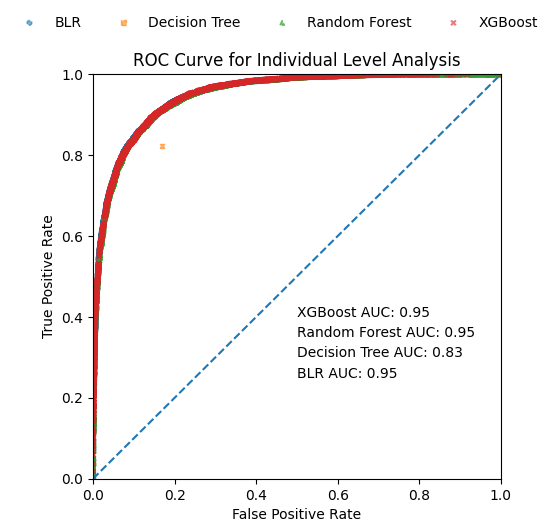

In [29]:
# function to plot the ROC curve for each model superimposed into one single plot
from sklearn.metrics import roc_curve, roc_auc_score

modelMap = {'BLR': model, 'Decision Tree': dtmodel, 'Random Forest': rfmodel, 'XGBoost': xgb_model}
markers = ['o', 's', '^', 'x']
labelsArr = ['BLR', 'Decision Tree', 'Random Forest', 'XGBoost']

# Define a function to plot the ROC/AUC
def plotRocAuc(X, y):
    
    fig, ax = plt.subplots(figsize=(5, 5))

    # Plot the "dumb model" line
    ax.plot([0, 1], [0, 1], linestyle='--')

    # use a loop to pass each model
    for idx, (model_name, md) in enumerate(modelMap.items()):
        probabilities = md.predict_proba(X)
        probabilities = probabilities[:, 1]  # keep probabilities for first class only
        fpr, tpr, _ = roc_curve(y, probabilities) # compute FPR and TPR
        print(model_name, len(fpr), len(tpr))
        print(tpr[:10])
        print(fpr[:10])
        ax.scatter(fpr, tpr, marker=markers[idx], linestyle='--', s=12, alpha=0.6, label=labelsArr[idx]) # plot the ROC curve
        ax.text(0.5, (0.25 + 0.05 * idx), f"{model_name} AUC: " + str(round(roc_auc_score(y, probabilities),2))) # AUC value
    
    # show the plot
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

    ax.set_title('ROC Curve for Individual Level Analysis')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)

    # Customize legend
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncols=4, bbox_to_anchor=(0.5, 0.99), frameon=False, fontsize=10)


    plt.tight_layout()
    plt.show()

plotRocAuc(X_test, y_test)

In [31]:
X_train_scaled

array([[-0.0432248 , -0.01545931],
       [ 0.66712296,  0.69085603],
       [ 1.12991643, -1.13695973],
       ...,
       [ 0.59484227, -0.08536983],
       [ 1.18230481,  0.22834986],
       [ 0.81430322, -1.50598233]])

<Axes: xlabel='CooperativeFactor', ylabel='NonCooperativeFactor'>

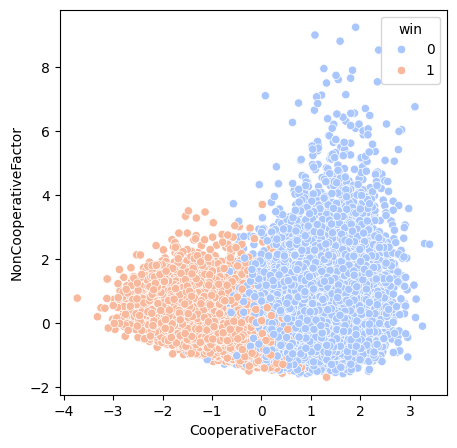

In [32]:
# plot the factor scores for each team using the two factor components in a 2D scatter plot
plt.figure(figsize=(5, 5))
sns.scatterplot(x='CooperativeFactor', y='NonCooperativeFactor', data=factors_with_win_info, hue='win', palette='coolwarm')

### Identifying the number of clusters using Elbow method, Silhouette Score and Davies-Bouldin Score

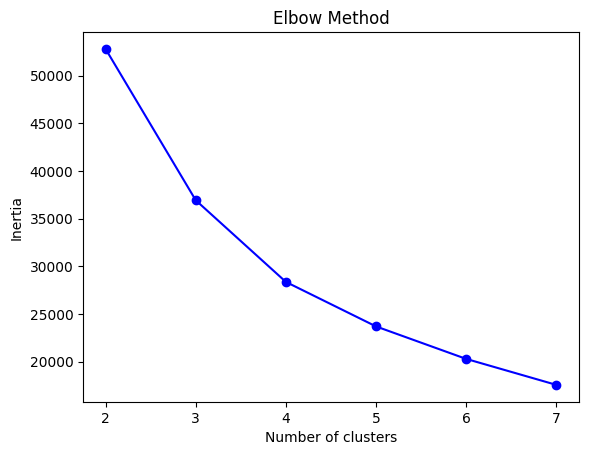

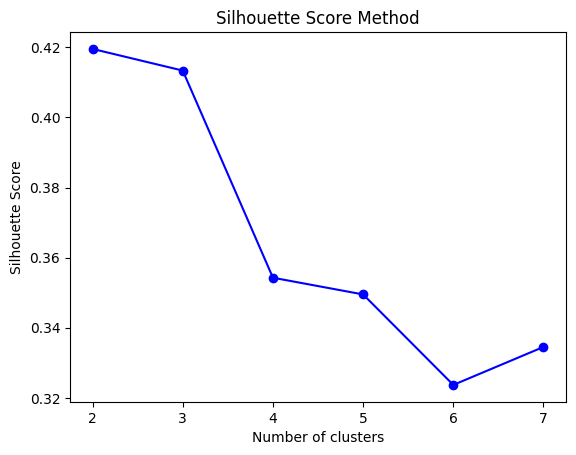

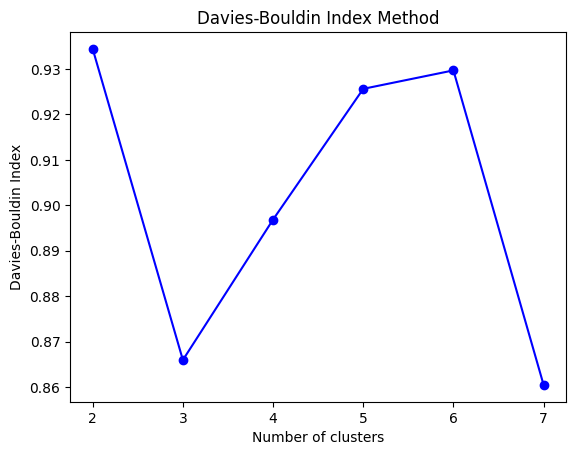

4


In [33]:
## Using the Elbow method
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score, davies_bouldin_score

silhouette_scores = []
db_scores = []

inertia = []
K = range(2, 8)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=12, n_init=10, max_iter=16)
    labels = kmeans.fit_predict(factor_scores_df)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(factor_scores_df, labels))
    db_scores.append(davies_bouldin_score(factor_scores_df, labels))

# plotting the elbow curve
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Plotting the Silhouette scores
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

# Plotting the Davies-Bouldin scores
plt.plot(K, db_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index Method')
plt.show()

## Use knee locator to identify the elbow point if the graph visually doesn't make sense
kl = KneeLocator(K, inertia, curve='convex', direction='decreasing')
print(kl.elbow)

In [34]:
factors_with_win_info

,gameId,teamId,win,averageTeamExpPerMin,averageTeamGoldPerMin,averageTeamVPM,teamIndegreeCentrality,teamOutdegreeCentrality,resistance,CooperativeFactor,NonCooperativeFactor
0,EUW1_7139824479,100,0,439.862735,367.2,0.926542,0.227941,0.080882,0.6500,0.731456,-0.738828
1,EUW1_7139824479,200,1,451.058445,387.8,0.701340,0.204545,0.172078,0.5907,0.201695,-0.065562
2,EUW1_7140549083,100,0,416.710163,380.4,0.971142,0.240196,0.142157,1.0599,0.419814,0.016391
3,EUW1_7140549083,200,1,544.592221,500.6,1.069009,0.174757,0.065534,0.4496,-2.502744,-0.102221
4,EUW1_7139855952,100,1,497.323814,423.4,1.199388,0.173729,0.067797,1.0129,-0.656660,-0.414528
...,...,...,...,...,...,...,...,...,...,...,...
62105,EUW1_7139969225,200,0,403.150485,352.6,0.851942,0.312500,0.125000,3.3925,1.052832,1.058529
62106,EUW1_7142645284,100,1,513.742765,414.2,0.964630,0.158163,0.119898,0.4297,-0.477343,-0.496168
62107,EUW1_7142645284,200,0,391.157556,297.4,0.836013,0.375000,0.125000,4.6447,2.322292,1.371913
62108,EUW1_7139963823,100,0,460.963983,393.4,1.302966,0.172535,0.059859,0.6575,0.099316,-0.860070


Elbow method and silhouette score suggest that number of clusters be N=4, say something like very good, good, bad, very bad! But for simplicity we take 2 clusters only! That is good vs bad

In [35]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10, max_iter=16)
kmeans.fit(factor_scores_df)

factors_with_win_info['team_labels'] = kmeans.labels_

factors_with_win_info

,gameId,teamId,win,averageTeamExpPerMin,averageTeamGoldPerMin,averageTeamVPM,teamIndegreeCentrality,teamOutdegreeCentrality,resistance,CooperativeFactor,NonCooperativeFactor,team_labels
0,EUW1_7139824479,100,0,439.862735,367.2,0.926542,0.227941,0.080882,0.6500,0.731456,-0.738828,0
1,EUW1_7139824479,200,1,451.058445,387.8,0.701340,0.204545,0.172078,0.5907,0.201695,-0.065562,2
2,EUW1_7140549083,100,0,416.710163,380.4,0.971142,0.240196,0.142157,1.0599,0.419814,0.016391,0
3,EUW1_7140549083,200,1,544.592221,500.6,1.069009,0.174757,0.065534,0.4496,-2.502744,-0.102221,1
4,EUW1_7139855952,100,1,497.323814,423.4,1.199388,0.173729,0.067797,1.0129,-0.656660,-0.414528,2
...,...,...,...,...,...,...,...,...,...,...,...,...
62105,EUW1_7139969225,200,0,403.150485,352.6,0.851942,0.312500,0.125000,3.3925,1.052832,1.058529,3
62106,EUW1_7142645284,100,1,513.742765,414.2,0.964630,0.158163,0.119898,0.4297,-0.477343,-0.496168,2
62107,EUW1_7142645284,200,0,391.157556,297.4,0.836013,0.375000,0.125000,4.6447,2.322292,1.371913,3
62108,EUW1_7139963823,100,0,460.963983,393.4,1.302966,0.172535,0.059859,0.6575,0.099316,-0.860070,2


### Identify whether a given team label is a good team or a bad team based on the frequency of number of wins registered by such labels

In [36]:
# counts of team types in each cluster
factors_with_win_info['team_labels'].value_counts()

team_labels
2    22340
0    18219
1    16050
3     5501
Name: count, dtype: int64

### That there are 32.8K teams of label type 1 and 29.2K teams of label type 2

In [37]:
# what types of teams are dominant in losing sets
factors_with_win_info[factors_with_win_info['win'] == 0]['team_labels'].value_counts()

team_labels
0    17267
2     7829
3     5349
1      610
Name: count, dtype: int64

In [38]:
# what types of teams are dominant in winning sets
factors_with_win_info[factors_with_win_info['win'] == 1]['team_labels'].value_counts()

team_labels
1    15440
2    14511
0      952
3      152
Name: count, dtype: int64

In [39]:
# average values of performance metrics for each cluster
cluster_avg = factors_with_win_info.groupby('team_labels')[['CooperativeFactor', 'NonCooperativeFactor']].mean()

In [40]:
cluster_avg

,CooperativeFactor,NonCooperativeFactor
team_labels,,
0,0.988749,-0.254079
1,-1.194216,0.252901
2,-0.222668,-0.351864
3,1.113898,1.532566


### Team labels 1 and 2, are good teams, as earlier plot of Cooperative and NonCooperative factors with win hue shows negative cooperative factors win more often and the average values of the team labels suggest the same

In [41]:
factors_with_win_info['isGoodTeam'] = factors_with_win_info['team_labels'].apply(lambda x: True if (x == 1 or x == 2) else False)
factors_with_win_info

,gameId,teamId,win,averageTeamExpPerMin,averageTeamGoldPerMin,averageTeamVPM,teamIndegreeCentrality,teamOutdegreeCentrality,resistance,CooperativeFactor,NonCooperativeFactor,team_labels,isGoodTeam
0,EUW1_7139824479,100,0,439.862735,367.2,0.926542,0.227941,0.080882,0.6500,0.731456,-0.738828,0,False
1,EUW1_7139824479,200,1,451.058445,387.8,0.701340,0.204545,0.172078,0.5907,0.201695,-0.065562,2,True
2,EUW1_7140549083,100,0,416.710163,380.4,0.971142,0.240196,0.142157,1.0599,0.419814,0.016391,0,False
3,EUW1_7140549083,200,1,544.592221,500.6,1.069009,0.174757,0.065534,0.4496,-2.502744,-0.102221,1,True
4,EUW1_7139855952,100,1,497.323814,423.4,1.199388,0.173729,0.067797,1.0129,-0.656660,-0.414528,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62105,EUW1_7139969225,200,0,403.150485,352.6,0.851942,0.312500,0.125000,3.3925,1.052832,1.058529,3,False
62106,EUW1_7142645284,100,1,513.742765,414.2,0.964630,0.158163,0.119898,0.4297,-0.477343,-0.496168,2,True
62107,EUW1_7142645284,200,0,391.157556,297.4,0.836013,0.375000,0.125000,4.6447,2.322292,1.371913,3,False
62108,EUW1_7139963823,100,0,460.963983,393.4,1.302966,0.172535,0.059859,0.6575,0.099316,-0.860070,2,True


In [38]:
factors_with_win_info.to_csv('../dataset/team_factor_and_labels.csv', index=False)